## Fig. 5 Robustness to heterogeniety and overlap.



In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root
from scipy.linalg import eig
from scipy.interpolate import interp1d
import pywt
import os
from QIFNetwork import *
from FREs import *


In [5]:
# config for plotting. copied from 修論
config = {
        'font.family' : 'sans-serif',
        'font.size' : 12.0,
        'xtick.direction' : 'in',
        'ytick.direction' : 'in',
        'axes.xmargin' : 0.1,
        'axes.ymargin' : 0.11,
        'axes.linewidth' : 1.0,
        'axes.titlelocation' : 'left',
        'lines.linewidth' : 0.7,
        'legend.fancybox' : False,
        'legend.loc' : 'upper right'
    }
plt.rcParams.update(config)
# label = ['(' + chr(ord("a")+i) + ')' for i in range(26)]
savedir = 'fig5/'
os.makedirs(savedir, exist_ok=True)

まずはsynaptic heterogenietyから.

In [6]:
# parameters
J1 = 15; J2 = 15; eta = -5; delta = 1.0
P = 10

In [7]:
t0 = 0; t1 = 100
t_eval = np.linspace(t0, t1, 10000)

# compute fixed points
focus = root(lambda y : fre_single(0, y, J2, eta, delta), [[1, 0]]).x
node = root(lambda y : fre_single(0, y, J2, eta, delta), [[0, -2]]).x
saddle = root(lambda y : fre_single(0, y, J2, eta, delta), [[0.5, -0.5]]).x

In [8]:
# simulation of FRE
t0 = -0.1; t1 = 1.5
t_uniform = np.linspace(t0, t1, 2**13, dtype='float64')

y0 = np.repeat(node, P)
# y0[0] += 0; y0[P] += 10.0
i_impulse_amp = 10.0
sol1 = solve_ivp(fre_seq, (t0, 0), y0, t_eval=t_uniform[t_uniform <= 0], args = (J1, J2, eta, delta, P), rtol=1e-10, atol=1e-10) # NOTE : r_k = y[k], v_k = y[k+P]
y0_jump = sol1.y[:, -1] + i_impulse_amp * np.eye(2*P)[P]
sol2 = solve_ivp(fre_seq, (0, t1), y0_jump, t_eval=t_uniform[t_uniform > 0], args = (J1, J2, eta, delta, P), rtol=1e-10, atol=1e-10) # NOTE : r_k = y[k], v_k = y[k+P]

t_sol = np.concatenate((sol1.t, sol2.t))
y_sol = np.concatenate((sol1.y, sol2.y), axis=1)


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
params = {'syn_delay' : 1e-8,
          'vmin' : -100,
          'vmax' : 100,
          'device' : device}
print(params)

{'syn_delay': 1e-08, 'vmin': -100, 'vmax': 100, 'device': 'cuda'}


In [10]:
def simulate_synaptic_heterogeneity(N, BS, t0, t1, noise_level):
    """
    Simulate the network with synaptic heterogeneity.
    """
    w_rec = J2 * np.eye(P)
    # feedforward connection
    w_ff = J1 * np.roll(np.eye(P), 1, axis = 0) - (J1/P) * np.ones((P, P), dtype = 'float')
    w_fre = w_ff + w_rec


    # -------------------------------
    # 1. 対数正規ノイズを作る
    # -------------------------------
    sigma_ln = noise_level                        # 対数正規分布の標準偏差 (log 空間)
    noise = torch.exp(sigma_ln * torch.randn(N, N,
                                            dtype=torch.float32,
                                            device=device))
    # 平均1にリスケール（ネット全体の結合強度を保つため推奨）
    noise /= noise.mean()

    # QIF でのweight
    # ニューロン数で正規化するのを忘れないこと.
    # 最初転置していたけど, 転置いらないっぽい.
    w_net = torch.kron(torch.tensor(w_fre.copy(), dtype = torch.float32, device=device), 
                    noise) / N 

    # グループごとに入力を受け取るために, input_size = Pとする
    net = QIFNetwork(P, N*P, P, params).to(device)
    # パラメータを初期化
    with torch.no_grad():
        # set i2h weight and bias
        group2neuron = torch.kron(torch.eye(P), torch.ones(N, 1))  # 各行がどの列(P)を取るかを示すマスク
        net.i2h.weight.copy_(group2neuron)
        net.i2h.bias.zero_()              # 外部電流にバイアスは不要
        # set h2h weight and bias
        net.h2h.weight.copy_(w_net)
        net.h2h.bias.copy_(torch.tensor(rng.standard_cauchy(size = net.hidden_size) * delta + eta))
        # set h2o weight and bias
        net.h2o.weight.copy_(
            torch.kron(torch.eye(P, dtype = torch.float32, device=device), torch.ones(1, N, dtype = torch.float32, device=device)) / N
        )
        # net.h2o.bias.copy_(torch.tensor(0))
        net.h2o.bias.zero_()
    for param in net.parameters():
        param.requires_grad = False 

    net.eval()
    x_rec = []
    t_rec = []
    r_rec = []
    k_rec = []
    # reset initial conditions
    v_init = rng.standard_cauchy(size = (BS, N*P)) * np.pi * np.repeat(y0[:P], N) + np.repeat(y0[P:], N)
    v = torch.tensor(v_init, dtype = torch.float32, device=device)

    t = torch.ones(BS, dtype = torch.float32, device=device) * t0

    spikes = 0
    # ――― ループに入る前に ―――
    ext_done = torch.zeros(BS, dtype=torch.bool, device=device)   # まだパルスを撃っていないバッチを管理

    while torch.all(torch.logical_and(t< t1, torch.logical_not(torch.isnan(t)))): # すべてのサブバッチでt < t1 かつ tがnanでないとき
        with torch.no_grad():
            # ── ① 外部パルスを決める ───────────────────────────
            #    ・すでに発火させたサンプル(ext_done==True)はスキップ
            #    ・現在の時刻 t が 0 以上になったサンプルだけに +10 を撃つ
            need_pulse = (~ext_done) & (t >= 0)          # shape = (BS,)

            input_spike = torch.zeros(
                BS, net.hidden_size, dtype=torch.float32, device=device
            )
            if need_pulse.any():
                input_spike[need_pulse, :N] = 10.0       # group-0 は隣接 N 個のニューロン
                ext_done |= need_pulse                   # 二度撃たないようフラグ更新

            # ── ② 連続電流は常にゼロ ──────────────────────────
            input_current = torch.zeros(
                BS, P, dtype=torch.float32, device=device
            )
            # # ――― 外部入力を計算 ―――
            # # t はバッチ毎に異なるので、サンプルごとに i_ext を呼ぶ
            # i_ext_batch = np.stack([i_ext(t_b.item()) for t_b in t.cpu()])   # shape = (BS, P)
            # input_current = torch.tensor(i_ext_batch, dtype=torch.float32, device=device)


            # ――― 1 ステップ進める ―――
            output_spike, output_potential, v, t, dt, k = net(
                input_spike, input_current, v, t
            )
            
            # print(output_spike.numpy(force = True), output_potential.numpy(force=True), t.numpy(force = True), dt, k)
            x_rec.append(output_potential.numpy(force = True))
            r_rec.append(output_spike.numpy(force = True))
            t_rec.append(t.numpy(force = True))
            k_rec.append(k.numpy(force = True))
            
        if torch.isnan(output_potential).any() or torch.isnan(output_spike).any() or torch.isnan(t).any() or torch.isnan(v).any() or torch.isnan(dt).any() or torch.isnan(k).any():
            print(f"nan detected at updating {spikes} -th spike.")
            print(output_spike, output_potential, t, v, dt, k)
            break
        spikes += 1

        if spikes % 5000 == 0:
            print(t.numpy(force = True), spikes)

    x_rec = np.array(x_rec)
    r_rec = np.array(r_rec)
    t_rec = np.array(t_rec)
    k_rec = np.array(k_rec)
    return x_rec, r_rec, t_rec, k_rec

In [37]:
N = 4096; BS = 8
small_noise = 1.0; large_noise = 2.0
simulation1 = simulate_synaptic_heterogeneity(N, BS, t0, t1, small_noise)
simulation2 = simulate_synaptic_heterogeneity(N, BS, t0, t1, large_noise)

[0.1951 0.1981 0.1951 0.1978 0.1953 0.1995 0.191  0.199 ] 5000
[0.3243 0.3245 0.3244 0.3247 0.3239 0.3245 0.3236 0.3243] 10000
[0.4375 0.4374 0.4379 0.4385 0.4375 0.4375 0.4371 0.4375] 15000
[0.5516 0.5518 0.5524 0.5527 0.5518 0.5518 0.5518 0.5519] 20000
[0.6659 0.6658 0.6667 0.6668 0.6659 0.6658 0.6658 0.6662] 25000
[0.7852 0.787  0.7871 0.7876 0.7863 0.786  0.7849 0.787 ] 30000
[0.9922 0.9925 0.9928 0.9933 0.9923 0.9922 0.9921 0.9925] 35000
[1.108  1.108  1.1085 1.109  1.1081 1.108  1.1081 1.1084] 40000
[1.2216 1.2216 1.2222 1.2226 1.2219 1.2215 1.2218 1.222 ] 45000
[1.3353 1.3355 1.3359 1.3365 1.3358 1.3352 1.3356 1.3357] 50000
[1.4518 1.4525 1.4524 1.4533 1.4522 1.4518 1.4518 1.4527] 55000
[0.1856 0.1875 0.1881 0.1872 0.1916 0.1888 0.1902 0.1898] 5000
[0.3198 0.3199 0.3203 0.3199 0.3213 0.3203 0.3209 0.3208] 10000
[0.4448 0.444  0.445  0.4444 0.4454 0.4448 0.445  0.4451] 15000
[0.5702 0.5697 0.5705 0.57   0.5708 0.5705 0.5703 0.5704] 20000
[0.6945 0.6941 0.6946 0.6943 0.6952 0.6945

(55445, 8, 10) (55445, 8, 10) (55445, 8) (55445, 8)
(52066, 8, 10) (52066, 8, 10) (52066, 8) (52066, 8)


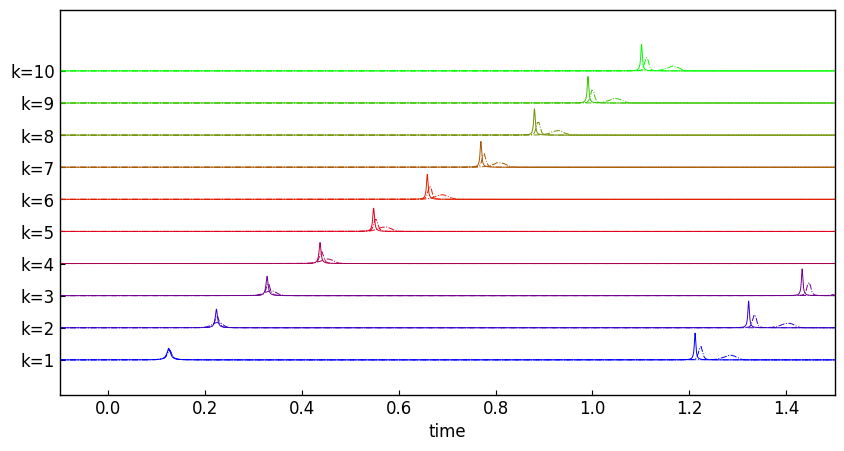

In [40]:

fig, ax = plt.subplots(figsize=(10, 5))
offset = r_sol.max() * 1.2          # 行間
colors = plt.cm.brg(np.linspace(0, 1, P))
r_sol = y_sol[:P]
v_sol = y_sol[P:]
for k in range(P):
    ax.plot(t_sol, r_sol[k] + k*offset, c = colors[k], ls = '-')

for noise_level, simulation in zip([small_noise, large_noise], [simulation1, simulation2]):
    x_rec, r_rec, t_rec, k_rec = simulation
    print(x_rec.shape, r_rec.shape, t_rec.shape, k_rec.shape)
    t_plot = np.linspace(t0, t1,512)
    x_plot = resample_time_series(x_rec, t_rec, t_plot)

    r_plot = resample_time_series(r_rec, t_rec, t_plot)
    r_total = np.zeros_like(t_plot)
    for t in t_rec.flatten():
        idx = np.argmin(t_plot < t)
        r_total[idx] += 1
    r_plot *= r_total.reshape(-1, 1) / (BS * (t_plot[1] - t_plot[0]))
    ls = '--' if noise_leve == small_noise else '-.'
    for k in range(P):
        ax.plot(t_plot, r_plot[:, k] + k*offset, ls=ls, c = colors[k])
ax.set_xlabel('time')
ax.set_yticks(offset*np.arange(P))
ax.set_yticklabels([f'k={k+1}' for k in range(P)])
ax.set_xlim(t0, t1)
plt.savefig(savedir + 'heterogeneity_offset.pdf', bbox_inches='tight')
plt.show()


plotting firing rate
(55445, 8, 10) (55445, 8, 10) (55445, 8) (55445, 8)
(52066, 8, 10) (52066, 8, 10) (52066, 8) (52066, 8)


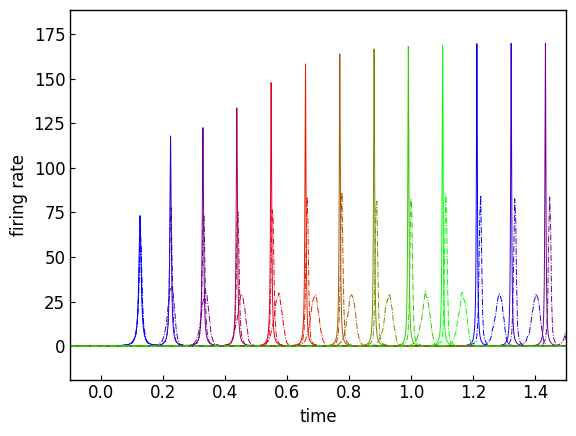

In [43]:
colors = plt.cm.brg(np.linspace(0, 1, P))

print('plotting firing rate')
# for p in range(P):
#     plt.plot(t_plot, r_plot[:, p], ls = '--', c = colors[p])
# for p in range(P):
#     plt.plot(sol.t, sol.y[p], ls = '-', c = colors[p])
for p in range(P):
    plt.plot(t_sol, y_sol[p], ls = '-', c = colors[p])
for noise_level, simulation in zip([small_noise, large_noise], [simulation1, simulation2]):
    x_rec, r_rec, t_rec, k_rec = simulation
    print(x_rec.shape, r_rec.shape, t_rec.shape, k_rec.shape)
    t_plot = np.linspace(t0, t1,512)
    x_plot = resample_time_series(x_rec, t_rec, t_plot)
    r_plot = resample_time_series(r_rec, t_rec, t_plot)
    r_total = np.zeros_like(t_plot)
    for t in t_rec.flatten():
        idx = np.argmin(t_plot < t)
        r_total[idx] += 1
    r_plot *= r_total.reshape(-1, 1) / (BS * (t_plot[1] - t_plot[0]))
    ls = '--' if noise_leve == small_noise else '-.'
    for p in range(P):
        plt.plot(t_plot, r_plot[:, p], ls = ls, c = colors[p])
# plt.legend()
plt.xlim(t0, t1)
plt.xlabel('time')
plt.ylabel('firing rate')
plt.savefig(savedir + 'heterogeneity_firing_rate.pdf', bbox_inches='tight')
plt.show()


plotting firing rate
(55445, 8, 10) (55445, 8, 10) (55445, 8) (55445, 8)
(52066, 8, 10) (52066, 8, 10) (52066, 8) (52066, 8)


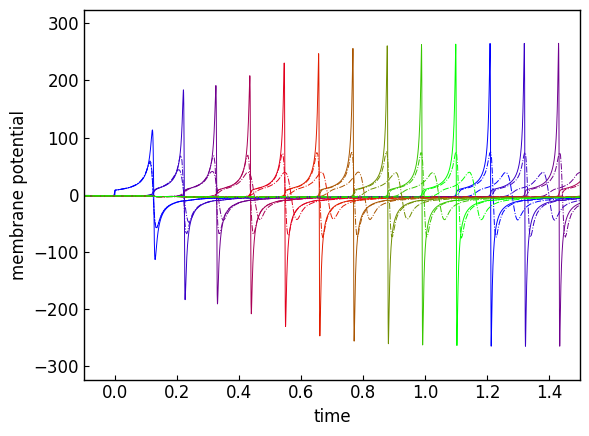

In [44]:
colors = plt.cm.brg(np.linspace(0, 1, P))

print('plotting firing rate')
# for p in range(P):
#     plt.plot(t_plot, r_plot[:, p], ls = '--', c = colors[p])
# for p in range(P):
#     plt.plot(sol.t, sol.y[p], ls = '-', c = colors[p])
for p in range(P):
    plt.plot(t_sol, y_sol[p+P], ls = '-', c = colors[p])
for noise_level, simulation in zip([small_noise, large_noise], [simulation1, simulation2]):
    x_rec, r_rec, t_rec, k_rec = simulation
    print(x_rec.shape, r_rec.shape, t_rec.shape, k_rec.shape)
    t_plot = np.linspace(t0, t1,512)
    x_plot = resample_time_series(x_rec, t_rec, t_plot)
    r_plot = resample_time_series(r_rec, t_rec, t_plot)
    r_total = np.zeros_like(t_plot)
    for t in t_rec.flatten():
        idx = np.argmin(t_plot < t)
        r_total[idx] += 1
    r_plot *= r_total.reshape(-1, 1) / (BS * (t_plot[1] - t_plot[0]))
    ls = '--' if noise_leve == small_noise else '-.'
    for p in range(P):
        plt.plot(t_plot, x_plot[:, p], ls = ls, c = colors[p])
# plt.legend()
plt.xlim(t0, t1)
plt.xlabel('time')
plt.ylabel('membrane potential')
plt.savefig(savedir + 'heterogeneity_membrane_potential.pdf', bbox_inches='tight')
plt.show()


次はoverlapping memory.

In [12]:
def simulate_overlap_memory(N, f, P, t0, t1):
    memory = np.zeros((P, N))
    memory[:, :int(N*f)] = 1
    for p in range(P):
        rng.shuffle(memory[p])
    memory_mean = np.mean(memory, axis=0, keepdims=True)
    # w = J1 * (np.roll(memory, -1, axis= 0).T -f) @ (memory-f) /(N * f) \
    #     + J2 * (memory.T - f) @ (memory - f) / (N * f) 
    # w = J1 * (np.roll(memory, -1, axis= 0).T ) @ (memory -f)/(N * f) \
    #     + J2 * memory.T @ memory / (N * f) 
    # w = J1 * np.roll(memory, -1, axis= 0).T @ memory / (N*f) \
    #     + J2 * memory.T @ memory / (N*f) \
    #     - J1 * memory.T @ np.mean(memory, axis = 1, keepdims=True) / (N*f) \
    w = J1 * np.roll(memory, -1, axis= 0).T @ memory / (N*f) \
        + J2 * memory.T @ memory / (N*f) \
        - J1 * np.repeat(memory_mean, P, axis = 0).T @ memory / (N*f) \



    net = QIFNetwork(1, N, P, params).to(device)
    # パラメータを初期化
    with torch.no_grad():
        net.h2h.weight.copy_(torch.tensor(w))
        net.h2h.bias.copy_(torch.tensor(rng.standard_cauchy(size = net.hidden_size) * delta + eta))
        net.h2o.weight.copy_(torch.tensor(memory / (N*f)))
        net.h2o.bias.copy_(torch.tensor(0))
        net.i2h.weight.copy_(torch.ones(net.hidden_size, net.input_size))
        net.i2h.bias.copy_(torch.tensor(0))
    for param in net.parameters():
        param.requires_grad = False 
        
    net.eval()
    x_rec = []
    t_rec = []
    r_rec = []
    k_rec = []
    # reset initial conditions
    # initial overlap with memory
    y0 = np.repeat(node, P); y0[P] += i_impulse_amp
    v_init = rng.standard_cauchy(size = (BS, N)) * (y0[:P] @ memory) + (y0[P:] @ memory)

    v = torch.tensor(v_init, dtype = torch.float32, device=device)

    # t = torch.ones(BS, dtype = torch.float32, device=device) * t0
    t = torch.ones(BS, dtype = torch.float32, device=device) * 0.0

    spikes = 0

    while torch.all(torch.logical_and(t< t1, torch.logical_not(torch.isnan(t)))): # すべてのサブバッチでt < t1 かつ tがnanでないとき
        with torch.no_grad():
            input_spike = torch.zeros(BS, net.hidden_size, dtype = torch.float32, device=device)
            input_current = torch.zeros(BS, net.input_size, dtype = torch.float32, device=device)
            
            output_spike, output_potential, v, t, dt, k = net(input_spike, input_current, v, t)
            x_rec.append(output_potential.numpy(force = True))
            r_rec.append(output_spike.numpy(force = True))
            t_rec.append(t.numpy(force = True))
            k_rec.append(k.numpy(force = True))
            
        if torch.isnan(output_potential).any() or torch.isnan(output_spike).any() or torch.isnan(t).any() or torch.isnan(v).any() or torch.isnan(dt).any() or torch.isnan(k).any():
            print(f"nan detected at updating {spikes} -th spike.")
            print(output_spike, output_potential, t, v, dt, k)
            break
        spikes += 1

        if spikes % 5000 == 0:
            print(t.numpy(force = True), spikes)

    x_rec = np.array(x_rec)
    r_rec = np.array(r_rec)
    t_rec = np.array(t_rec)
    k_rec = np.array(k_rec)
    print(x_rec.shape, r_rec.shape, t_rec.shape, k_rec.shape)
    return x_rec, r_rec, t_rec, k_rec

In [15]:
N = 2**14; BS = 8
overlap_small = 0.01
overlap_large = 0.1
simulation3 = simulate_overlap_memory(N, overlap_small, P, t0, t1)
simulation4 = simulate_overlap_memory(N, overlap_large, P, t0, t1)

(3736, 8, 10) (3736, 8, 10) (3736, 8) (3736, 8)
[0.4816 0.4824 0.4827 0.4819 0.4817 0.4836 0.4822 0.4809] 5000
[0.8298 0.8299 0.8294 0.8291 0.8288 0.8313 0.8292 0.8283] 10000
[1.1741 1.1744 1.1742 1.1736 1.1735 1.1754 1.1735 1.1732] 15000
(19868, 8, 10) (19868, 8, 10) (19868, 8) (19868, 8)


(3736, 8, 10) (3736, 8, 10) (3736, 8) (3736, 8)
(19868, 8, 10) (19868, 8, 10) (19868, 8) (19868, 8)


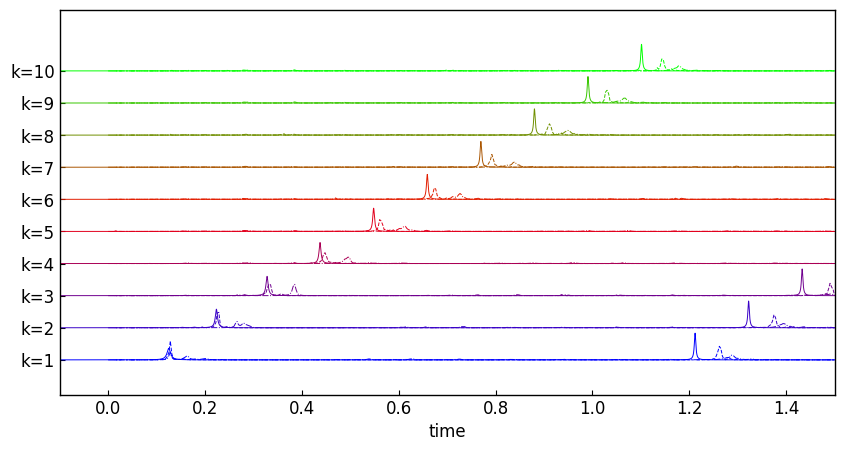

In [17]:
r_sol = y_sol[:P]
v_sol = y_sol[P:]

fig, ax = plt.subplots(figsize=(10, 5))
offset = r_sol.max() * 1.2          # 行間
colors = plt.cm.brg(np.linspace(0, 1, P))
for k in range(P):
    ax.plot(t_sol, r_sol[k] + k*offset, c = colors[k], ls = '-')

for overlap_level, simulation in zip([overlap_small, overlap_large], [simulation3, simulation4]):
    x_rec, r_rec, t_rec, k_rec = simulation
    print(x_rec.shape, r_rec.shape, t_rec.shape, k_rec.shape)
    t_plot = np.linspace(t0, t1,512)
    x_plot = resample_time_series(x_rec, t_rec, t_plot)

    r_plot = resample_time_series(r_rec, t_rec, t_plot)
    r_total = np.zeros_like(t_plot)
    for t in t_rec.flatten():
        idx = np.argmin(t_plot < t)
        r_total[idx] += 1
    r_plot *= r_total.reshape(-1, 1) / (BS * (t_plot[1] - t_plot[0]))
    ls = '--' if overlap_level == overlap_small else '-.'
    for k in range(P):
        ax.plot(t_plot, r_plot[:, k] + k*offset, ls=ls, c = colors[k])
ax.set_xlabel('time')
ax.set_yticks(offset*np.arange(P))
ax.set_yticklabels([f'k={k+1}' for k in range(P)])
ax.set_xlim(t0, t1)
plt.savefig(savedir + 'overlap_offset.pdf', bbox_inches='tight')
plt.show()


plotting firing rate
(3736, 8, 10) (3736, 8, 10) (3736, 8) (3736, 8)
(19868, 8, 10) (19868, 8, 10) (19868, 8) (19868, 8)


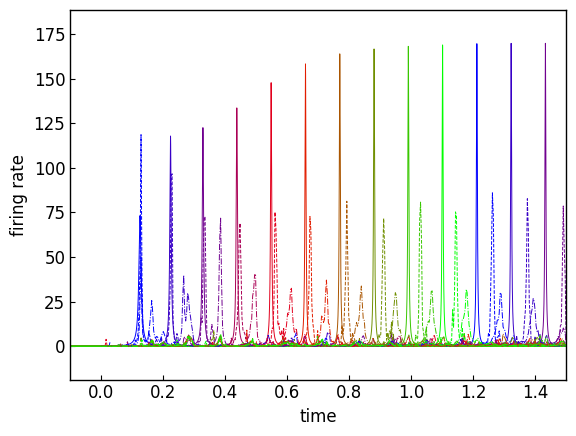

In [18]:
colors = plt.cm.brg(np.linspace(0, 1, P))

print('plotting firing rate')
# for p in range(P):
#     plt.plot(t_plot, r_plot[:, p], ls = '--', c = colors[p])
# for p in range(P):
#     plt.plot(sol.t, sol.y[p], ls = '-', c = colors[p])
for p in range(P):
    plt.plot(t_sol, y_sol[p], ls = '-', c = colors[p])
for overlap_level, simulation in zip([overlap_small, overlap_large], [simulation3, simulation4]):
    x_rec, r_rec, t_rec, k_rec = simulation
    print(x_rec.shape, r_rec.shape, t_rec.shape, k_rec.shape)
    t_plot = np.linspace(t0, t1,512)
    x_plot = resample_time_series(x_rec, t_rec, t_plot)
    r_plot = resample_time_series(r_rec, t_rec, t_plot)
    r_total = np.zeros_like(t_plot)
    for t in t_rec.flatten():
        idx = np.argmin(t_plot < t)
        r_total[idx] += 1
    r_plot *= r_total.reshape(-1, 1) / (BS * (t_plot[1] - t_plot[0]))
    ls = '--' if overlap_level == overlap_small else '-.'
    for p in range(P):
        plt.plot(t_plot, r_plot[:, p], ls = ls, c = colors[p])
# plt.legend()
plt.xlim(t0, t1)
plt.xlabel('time')
plt.ylabel('firing rate')
plt.savefig(savedir + 'overlap_firing_rate.pdf', bbox_inches='tight')
plt.show()


plotting membrane potential
(3736, 8, 10) (3736, 8, 10) (3736, 8) (3736, 8)
(19868, 8, 10) (19868, 8, 10) (19868, 8) (19868, 8)


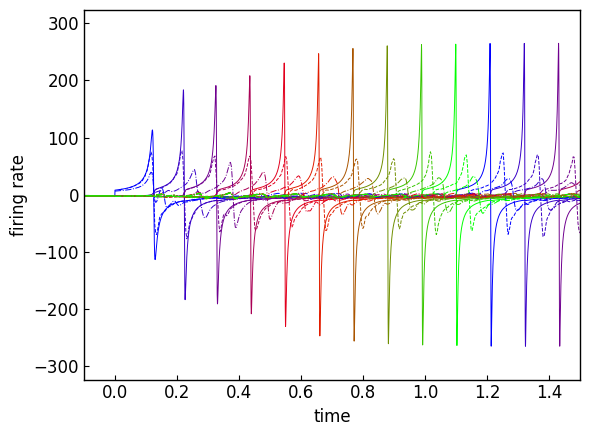

In [19]:
colors = plt.cm.brg(np.linspace(0, 1, P))

print('plotting membrane potential')
# for p in range(P):
#     plt.plot(t_plot, r_plot[:, p], ls = '--', c = colors[p])
# for p in range(P):
#     plt.plot(sol.t, sol.y[p], ls = '-', c = colors[p])
for p in range(P):
    plt.plot(t_sol, y_sol[p+P], ls = '-', c = colors[p])
for overlap_level, simulation in zip([overlap_small, overlap_large], [simulation3, simulation4]):
    x_rec, r_rec, t_rec, k_rec = simulation
    print(x_rec.shape, r_rec.shape, t_rec.shape, k_rec.shape)
    t_plot = np.linspace(t0, t1,512)
    x_plot = resample_time_series(x_rec, t_rec, t_plot)
    r_plot = resample_time_series(r_rec, t_rec, t_plot)
    r_total = np.zeros_like(t_plot)
    for t in t_rec.flatten():
        idx = np.argmin(t_plot < t)
        r_total[idx] += 1
    r_plot *= r_total.reshape(-1, 1) / (BS * (t_plot[1] - t_plot[0]))
    ls = '--' if overlap_level == overlap_small else '-.'
    for p in range(P):
        plt.plot(t_plot, x_plot[:, p], ls = ls, c = colors[p])
# plt.legend()
plt.xlim(t0, t1)
plt.xlabel('time')
plt.ylabel('firing rate')
plt.savefig(savedir + 'overlap_membrane_potential.pdf', bbox_inches='tight')
plt.show()


---
ここから下は古いコード

In [15]:
x_rec, r_rec, t_rec, k_rec = simulate_overlap_memory(N = 2**14, f = 0.01, P = 10, t0 = t0, t1 = t1)
t_plot = np.linspace(t0, t1,512)
x_plot = resample_time_series(x_rec, t_rec, t_plot)

r_plot = resample_time_series(r_rec, t_rec, t_plot)
r_total = np.zeros_like(t_plot)
for t in t_rec.flatten():
    idx = np.argmin(t_plot < t)
    r_total[idx] += 1
r_plot *= r_total.reshape(-1, 1) / (BS * (t_plot[1] - t_plot[0]))

(3818, 16, 10) (3818, 16, 10) (3818, 16) (3818, 16)


plotting firing rate


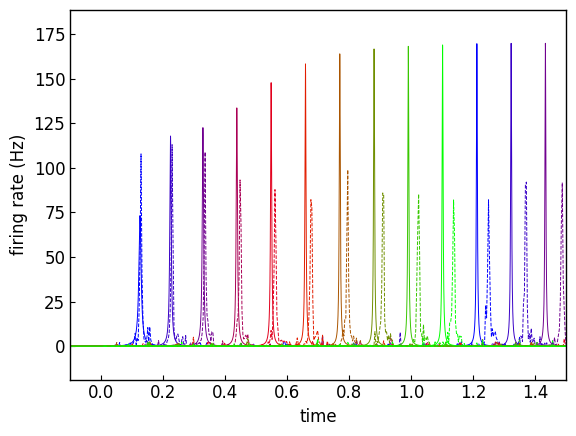

plotting membrane potential


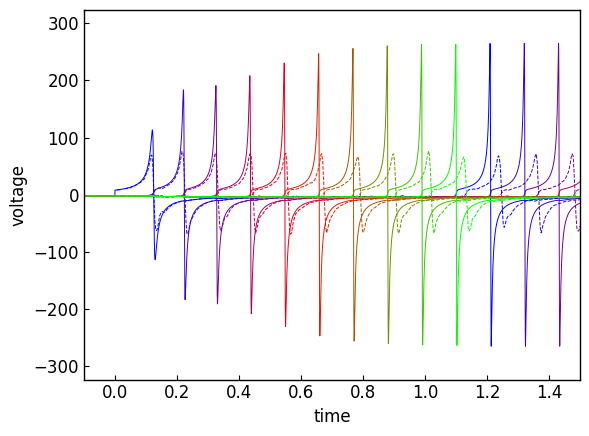

In [16]:
colors = plt.cm.brg(np.linspace(0, 1, P))

print('plotting firing rate')
for p in range(P):
    plt.plot(t_sol, y_sol[p], ls = '-', c = colors[p])
    plt.plot(t_plot, r_plot[:, p], ls = '--', c = colors[p])
# plt.legend()
plt.xlim(t0, t1)
plt.xlabel('time')
plt.ylabel('firing rate (Hz)')
plt.savefig(savedir + 'overlap_memory_firing_rate.pdf', bbox_inches='tight')
plt.show()

print('plotting membrane potential')
for p in range(P):
    plt.plot(t_sol, y_sol[p+P], ls = '-', c = colors[p])
    plt.plot(t_plot, x_plot[:, p], ls = '--', c = colors[p])
# plt.legend()    
plt.xlabel('time')
plt.ylabel('voltage')
plt.savefig(savedir + 'overlap_memory_membrane_potential.pdf', bbox_inches='tight')
plt.xlim(t0, t1)
plt.show()

In [ ]:
N = 2048; BS = 16
# recurrent connection
w_rec = J2 * np.eye(P)
# feedforward connection
w_ff = J1 * np.roll(np.eye(P), 1, axis = 0) - (J1/P) * np.ones((P, P), dtype = 'float')
w_fre = w_ff + w_rec


# -------------------------------
# 1. 対数正規ノイズを作る
# -------------------------------
sigma_ln = 1.5                        # 対数正規分布の標準偏差 (log 空間)
noise = torch.exp(sigma_ln * torch.randn(N, N,
                                         dtype=torch.float32,
                                         device=device))
# 平均1にリスケール（ネット全体の結合強度を保つため推奨）
noise /= noise.mean()

# QIF でのweight
# ニューロン数で正規化するのを忘れないこと.
# 最初転置していたけど, 転置いらないっぽい.
w_net = torch.kron(torch.tensor(w_fre.copy(), dtype = torch.float32, device=device), 
                   noise) / N 

# グループごとに入力を受け取るために, input_size = Pとする
net = QIFNetwork(P, N*P, P, params).to(device)
# パラメータを初期化
with torch.no_grad():
    # set i2h weight and bias
    group2neuron = torch.kron(torch.eye(P), torch.ones(N, 1))  # 各行がどの列(P)を取るかを示すマスク
    net.i2h.weight.copy_(group2neuron)
    net.i2h.bias.zero_()              # 外部電流にバイアスは不要
    # set h2h weight and bias
    net.h2h.weight.copy_(w_net)
    net.h2h.bias.copy_(torch.tensor(rng.standard_cauchy(size = net.hidden_size) * delta + eta))
    # set h2o weight and bias
    net.h2o.weight.copy_(
        torch.kron(torch.eye(P, dtype = torch.float32, device=device), torch.ones(1, N, dtype = torch.float32, device=device)) / N
    )
    # net.h2o.bias.copy_(torch.tensor(0))
    net.h2o.bias.zero_()
for param in net.parameters():
    param.requires_grad = False 


In [ ]:
# net.train()

net.eval()
x_rec = []
t_rec = []
r_rec = []
k_rec = []
# reset initial conditions
v_init = rng.standard_cauchy(size = (BS, N*P)) * np.pi * np.repeat(y0[:P], N) + np.repeat(y0[P:], N)
v = torch.tensor(v_init, dtype = torch.float32, device=device)

t = torch.ones(BS, dtype = torch.float32, device=device) * t0

spikes = 0
# print(y0[:P], y0[P:])

In [ ]:
# ――― ループに入る前に ―――
ext_done = torch.zeros(BS, dtype=torch.bool, device=device)   # まだパルスを撃っていないバッチを管理

while torch.all(torch.logical_and(t< t1, torch.logical_not(torch.isnan(t)))): # すべてのサブバッチでt < t1 かつ tがnanでないとき
    with torch.no_grad():
        # ── ① 外部パルスを決める ───────────────────────────
        #    ・すでに発火させたサンプル(ext_done==True)はスキップ
        #    ・現在の時刻 t が 0 以上になったサンプルだけに +10 を撃つ
        need_pulse = (~ext_done) & (t >= 0)          # shape = (BS,)

        input_spike = torch.zeros(
            BS, net.hidden_size, dtype=torch.float32, device=device
        )
        if need_pulse.any():
            input_spike[need_pulse, :N] = 10.0       # group-0 は隣接 N 個のニューロン
            ext_done |= need_pulse                   # 二度撃たないようフラグ更新

        # ── ② 連続電流は常にゼロ ──────────────────────────
        input_current = torch.zeros(
            BS, P, dtype=torch.float32, device=device
        )
        # # ――― 外部入力を計算 ―――
        # # t はバッチ毎に異なるので、サンプルごとに i_ext を呼ぶ
        # i_ext_batch = np.stack([i_ext(t_b.item()) for t_b in t.cpu()])   # shape = (BS, P)
        # input_current = torch.tensor(i_ext_batch, dtype=torch.float32, device=device)


        # ――― 1 ステップ進める ―――
        output_spike, output_potential, v, t, dt, k = net(
            input_spike, input_current, v, t
        )
        
        # print(output_spike.numpy(force = True), output_potential.numpy(force=True), t.numpy(force = True), dt, k)
        x_rec.append(output_potential.numpy(force = True))
        r_rec.append(output_spike.numpy(force = True))
        t_rec.append(t.numpy(force = True))
        k_rec.append(k.numpy(force = True))
        
    if torch.isnan(output_potential).any() or torch.isnan(output_spike).any() or torch.isnan(t).any() or torch.isnan(v).any() or torch.isnan(dt).any() or torch.isnan(k).any():
        print(f"nan detected at updating {spikes} -th spike.")
        print(output_spike, output_potential, t, v, dt, k)
        break
    spikes += 1

    if spikes % 5000 == 0:
        print(t.numpy(force = True), spikes)

x_rec = np.array(x_rec)
r_rec = np.array(r_rec)
t_rec = np.array(t_rec)
k_rec = np.array(k_rec)
print(x_rec.shape, r_rec.shape, t_rec.shape, k_rec.shape)

[0.324  0.3251 0.3252 0.3238 0.3243 0.3223 0.3244 0.3243 0.3251 0.3234
 0.3236 0.3243 0.3235 0.3226 0.3231 0.3256] 5000
[0.5622 0.5625 0.5638 0.5617 0.5623 0.5603 0.5627 0.5624 0.5635 0.5623
 0.5623 0.5625 0.562  0.5612 0.5611 0.564 ] 10000
[0.8076 0.809  0.8101 0.8072 0.8092 0.8054 0.8072 0.8089 0.8103 0.8063
 0.806  0.806  0.8073 0.8061 0.8059 0.8091] 15000
[1.1332 1.1331 1.1338 1.1318 1.1328 1.1308 1.1331 1.1335 1.1341 1.1331
 1.1327 1.1331 1.1321 1.1316 1.1315 1.1343] 20000
[1.3741 1.3744 1.375  1.3732 1.3741 1.3719 1.3741 1.3746 1.3753 1.374
 1.3737 1.3746 1.373  1.3725 1.3726 1.3753] 25000
(27543, 16, 10) (27543, 16, 10) (27543, 16) (27543, 16)


In [ ]:
t_plot = np.linspace(t0, t1,512)
x_plot = resample_time_series(x_rec, t_rec, t_plot)

r_plot = resample_time_series(r_rec, t_rec, t_plot)
r_total = np.zeros_like(t_plot)
for t in t_rec.flatten():
    idx = np.argmin(t_plot < t)
    r_total[idx] += 1
r_plot *= r_total.reshape(-1, 1) / (BS * (t_plot[1] - t_plot[0]))

plotting firing rate


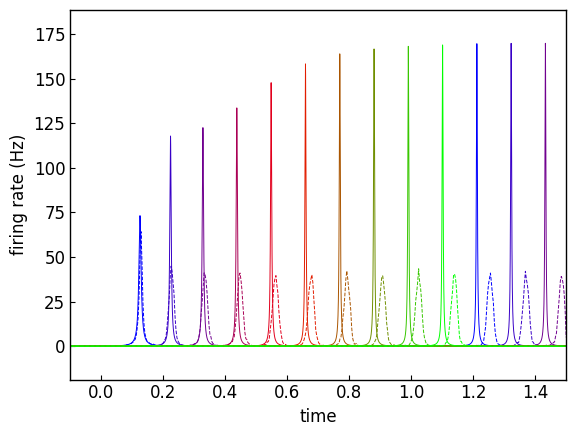

plotting membrane potential


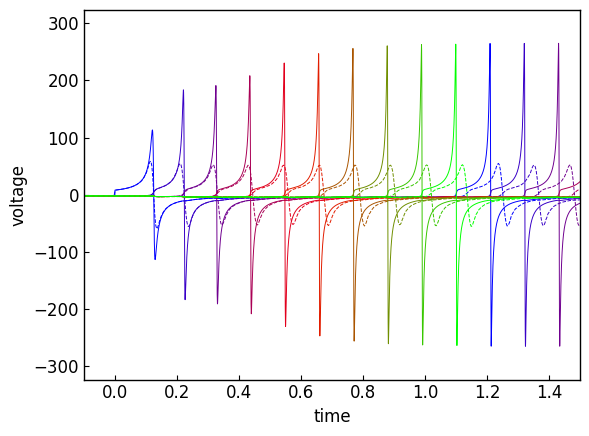

In [ ]:
colors = plt.cm.brg(np.linspace(0, 1, P))

print('plotting firing rate')
# for p in range(P):
#     plt.plot(t_plot, r_plot[:, p], ls = '--', c = colors[p])
# for p in range(P):
#     plt.plot(sol.t, sol.y[p], ls = '-', c = colors[p])
for p in range(P):
    plt.plot(t_sol, y_sol[p], ls = '-', c = colors[p])
    plt.plot(t_plot, r_plot[:, p], ls = '--', c = colors[p])
# plt.legend()
plt.xlim(t0, t1)
plt.xlabel('time')
plt.ylabel('firing rate (Hz)')
plt.savefig(savedir + 'heterosynapse_firing_rate.pdf', bbox_inches='tight')
plt.show()

print('plotting membrane potential')
for p in range(P):
    plt.plot(t_sol, y_sol[p+P], ls = '-', c = colors[p])
    plt.plot(t_plot, x_plot[:, p], ls = '--', c = colors[p])
# plt.legend()    
plt.xlabel('time')
plt.ylabel('voltage')
plt.savefig(savedir + 'heterosynapse_potential.pdf', bbox_inches='tight')
plt.xlim(t0, t1)
plt.show()